In [1]:
from copy import copy,deepcopy
from itertools import combinations
import json
import textwrap


from fisher import pvalue_npy
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
import requests
import requests_cache


requests_cache.install_cache(
    "pfocr_cache",
    allowable_methods=['GET', 'POST'],
    stale_if_error=False,
)
#requests_cache.remove_expired_responses()

# BTE: Cluster TRAPI Results by Selected PFOCR Figures

From discussion with Andrew, we want to first identify a set of figures that can serve to cluster the TRAPI results. We can call these the "cluster figures".

**Identify Cluster Figures**

We identify the top cluster figures by iteratively running Fisher's Exact Test to identify PFOCR figures that are most similar to all the CURIEs from the BTE TRAPI results. To get each cluster figure, we do the following:

1. Run Fisher's Exact Test for the CURIEs from each figure vs. the set of the unique CURIEs found from all the TRAPI results, limiting each  set of CURIEs to those with categories found in both PFOCR and BTE TRAPI, e.g., "disease" is found in PFOCR and "biolink:Disease" is found in BTE TRAPI
2. Select the figure with the lowest p-value as a cluster figure
3. Exclude that figure and the CURIEs in it
4. Repeat to get the next cluster figure, continuing until:
    - we run out of BTE TRAPI results
    - we run out of PFOCR figures
    - we've repeated steps 1-3 a certain number of times (currently limited to 15)

**Cluster BTE TRAPI Results by Selected PFOCR Figures (Cluster Figures)**

Once we have a set of cluster figures, we use them to cluster the BTE TRAPI results. We do this by running Fisher's Exact Test to identify which Cluster Figure each BTE TRAPI result is most similar to. We don't actually cluster the TRAPI results by figure, however, because if a result is highly relevant to two figures, it can show up in both. It's more accurate to think of the figure as being a different view of the TRAPI results.

**View TRAPI Results by PFOCR Figure**

With BTE TRAPI results "clustered" (not actually clustered, because we show the same result multiple times for different figures if it's closely related to both) by PFOCR figure, we display the top figures, each with their most closely related BTE TRAPI results.

## Get BTE TRAPI Results

imatinib (MESH:D000068877) - Gene - leukemia (MESH:D007938)

vs.

imatinib (MESH:D000068877) - Gene - asthma (MESH:D001249)

In [3]:
query = {
    "message": {
        "query_graph": {
            "edges": {
                "e0": {
                    "subject": "n0",
                    "object": "n1",
                    "predicates": [
                        "biolink:related_to"
                    ]
                },
                "e1": {
                    "subject": "n1",
                    "object": "n2",
                    "predicates": [
                        "biolink:related_to"
                    ]
                }
            },
            "nodes": {
                "n0": {
                    "ids": [
                        "MESH:D000068877"
                    ],
                    "categories": [
                        "biolink:Drug"
                    ]
                },
                "n1": {
                    "categories": [
                        "biolink:Gene"
                    ],
                },
                "n2": {
                    "ids": [
                        "MESH:D007938",
                        "MESH:D001249",
                    ],
                    "categories": [
                        "biolink:Disease"
                    ]
                }
            }
        }
    }
}

trapi_response = requests.post("http://localhost:3000/v1/query", json=query)
#trapi_response = requests.post("https://api.bte.ncats.io/v1/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/rtxkg2/v1.2/query", json=query)
#trapi_response = requests.post("https://arax.ncats.io/api/arax/v1.2/query", json=query)
print(trapi_response.status_code)
if trapi_response.status_code != 200:
    raise Exception(trapi_response.text)
if trapi_response.from_cache:
    print(f"got response from cache")

trapi_message = trapi_response.json()["message"]

if len(trapi_message["results"]) == 0:
    raise Exception(f'No results returned')

200
got response from cache


Analyze this GraphML file in Cytoscape: ./bte_sleeve_query_template.graphml


{('n0',
  'n1'): Text(-0.4991114276680917, 0.44576953724722523, 'biolink:related_to'),
 ('n1',
  'n2'): Text(0.49999999999999994, -0.44656318313571886, 'biolink:related_to')}

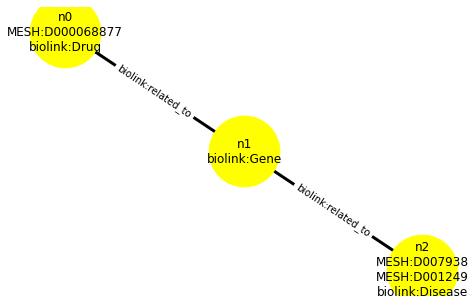

In [4]:
from collections import defaultdict


G = nx.Graph()
query_node_labels = {}
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    node_categories = v.get('categories', [])
    G.add_node(k, categories=', '.join(node_categories))
    query_node_labels[k] = '\n'.join([k] + node_ids + node_categories)
    #G.add_node(k, color='red')

query_edge_labels = {}
q_node_id_keys = set(['object', 'subject'])
for q_edge_id,edge_v in query['message']['query_graph']['edges'].items():
    for predicate in edge_v['predicates']:
        G.add_edge(edge_v['subject'], edge_v['object'], predicate=predicate)
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=', '.join(edge_v['predicates']))
    #G.add_edge(edge_v['subject'], edge_v['object'], predicates=[1,2,3])
    #G.add_edge(edge_v['subject'], edge_v['object'])
    query_edge_labels[(edge_v['subject'], edge_v['object'])] = '\n'.join(edge_v['predicates'])
    
query_template_f = './bte_sleeve_query_template.graphml'
print(f'Analyze this GraphML file in Cytoscape: {query_template_f}')
nx.write_graphml(G, query_template_f)

options = {
    'node_color': 'yellow',
    'node_size': 5000,
    'edge_color': 'black',
    'width': 3,
}
query_template_layout = nx.spring_layout(G)
nx.draw(G, pos=query_template_layout, **options)
nx.draw_networkx_labels(G, query_template_layout, labels=query_node_labels, font_size=12,
                        font_color='k', font_family='sans-serif',
                        font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                        verticalalignment='center', ax=None, clip_on=False)
nx.draw_networkx_edge_labels(G, pos=query_template_layout,
                             edge_labels=query_edge_labels,
                             label_pos=0.5, 
                             font_size=10, font_color='k', font_family='sans-serif',
                             font_weight='normal', alpha=None, bbox=None, horizontalalignment='center',
                             verticalalignment='center', ax=None, rotate=True, clip_on=True)

In [5]:
# NOTE: we're including categories specified in the query template
# in the next cell, and in a cell further down, we're also including
# any categories from the TRAPI results.
#
# TODO: Some categories are supersets of others. Should we handle
# this systematically?

curie_categories = set()
for v in query["message"]["query_graph"]["nodes"].values():
    if "categories" in v:
        for category in v["categories"]:
            curie_categories.add(category)

In [6]:
# for genes/gene products, chemicals and diseases
preferred_prefixes = set(["NCBIGene", "MESH"])
trapi_results_unified_curies = set()
unification_failed_curies = set()
unified_prefixes = set()
all_prefixes = set()
curie_to_name = dict()
curie_to_categories = dict()
curie_to_unified_curie = dict()
for k, v in trapi_message["knowledge_graph"]["nodes"].items():
    name = v["name"]
    categories = v["categories"]
    curie_categories |= set(categories)

    for a in v["attributes"]:
        if a["attribute_type_id"] == "biolink:xref":
            curies = a["value"]

            # k should always be one of the curies
            if not k in curies:
                raise Exception(f"key {k} not in {curies}")

            unified_curie = None
            intersecting_trapi_results_unified_curies = trapi_results_unified_curies.intersection(
                set(curies)
            )
            if len(intersecting_trapi_results_unified_curies) > 1:
                multiple_matches = list(intersecting_trapi_results_unified_curies)
                raise Exception(f"matching multiple: {k} to {multiple_matches}")
            elif len(intersecting_trapi_results_unified_curies) == 1:
                unified_curie = list(intersecting_trapi_results_unified_curies)[0]
            else:
                # get curie for preferred prefix. usually this is k, but not always.
                for curie in curies:
                    [prefix, identifier] = curie.split(":")
                    if prefix in preferred_prefixes:
                        unified_curie = curie
                        trapi_results_unified_curies.add(unified_curie)
                        break

            if not unified_curie:
                if k in curie_to_unified_curie:
                    unified_curie = curie_to_unified_curie[k]
                else:
                    unification_failed_curies.add(k)
                    break

                #raise Exception(f"failed to find a unified curie for {k} in {curies}")

            [unified_prefix, unified_identifier] = unified_curie.split(":")
            unified_prefixes.add(unified_prefix)

            for curie in curies:
                [prefix, identifier] = curie.split(":")
                all_prefixes.add(prefix)
                if not curie in curie_to_unified_curie:
                    curie_to_unified_curie[curie] = unified_curie
                if not curie in curie_to_name:
                    curie_to_name[curie] = name
                    curie_to_categories[curie] = categories
                elif curie_to_name[curie] != name:
                    print(f"curie {curie} has multiple primary names: {curie_to_name[curie]} and {name}")
                    #raise Exception(f"curie{curie} has multiple names: {curie_to_name[curie]} and {name}")


#print(f'curie_categories: {curie_categories}')
#print("")
#print(f"curie_to_name key count: {len(curie_to_name.keys())}")
#print(f"curie_to_unified_curie key count: {len(curie_to_unified_curie.keys())}")
#print("")
print("all CURIE prefixes found:")
print(all_prefixes)
print("")
print("unified CURIE prefixes found:")
print(unified_prefixes)
print("")
print(f"failed to unify {len(unification_failed_curies)} CURIEs")

all CURIE prefixes found:
{'ENSEMBL', 'CHEBI', 'NCBIGene', 'CAS', 'UniProtKB', 'INCHIKEY', 'UNII', 'SNOMEDCT', 'NCIT', 'MEDDRA', 'PR', 'MESH', 'HGNC', 'ICD0', 'ICD9', 'PUBCHEM.COMPOUND', 'HP', 'OMIM', 'DOID', 'UMLS', 'ICD10', 'MONDO', 'CHEMBL.COMPOUND'}

unified CURIE prefixes found:
{'MESH', 'NCBIGene'}

failed to unify 0 CURIEs


In [7]:
columns = []
q_node_id_keys = set(["object", "subject"])
q_node_ids = []
q_edge_ids = []
for q_edge_id,edge_v in query["message"]["query_graph"]["edges"].items():
    q_edge_ids.append(q_edge_id)
    q_node_id_found = False
    for k,v in edge_v.items():
        if (k in q_node_id_keys) and (type(v) is str):
            if v not in columns:
                q_node_ids.append(v)
                columns.append(v)
            if not q_node_id_found:
                q_node_id_found = True
                columns.append(q_edge_id)

query_nodes_with_ids = set()
for k, v in query['message']['query_graph']['nodes'].items():
    node_ids = v.get('ids', [])
    if node_ids:
        query_nodes_with_ids.add(k)

for q_node_id in q_node_ids:
    columns.append(f"{q_node_id}_original_curie")
    columns.append(f"{q_node_id}_unified_curie")

columns.append("unified_curie_set")

trapi_result_columns = []
for i in range(len(q_node_ids)):
    trapi_result_columns.append(q_node_ids[i])
    if i < len(q_edge_ids):
        trapi_result_columns.append(q_edge_ids[i])

unified_curie_columns = []
for q_node_id in q_node_ids:
    unified_curie_columns.append(f"{q_node_id}_unified_curie")

In [8]:
trapi_results = trapi_message["results"]

result_row_data = []
for trapi_result in trapi_results:
    curie_to_qnode_ids = dict()
    for qnode_id, entries in trapi_result["node_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            if curie not in curie_to_qnode_ids:
                curie_to_qnode_ids[curie] = []
            curie_to_qnode_ids[curie].append(qnode_id)

    row_data_template = dict()
    q_edge_id_to_predicates = dict()
    trapi_result_curie_set = set()
    for qedge_id, entries in trapi_result["edge_bindings"].items():
        for entry in entries:
            curie = entry["id"]
            kg_entry = trapi_message["knowledge_graph"]["edges"][curie]
            subject_curie = kg_entry["subject"]
            object_curie = kg_entry["object"]
            predicate_curie = kg_entry["predicate"]
            [predicate_prefix, predicate_identifier] = predicate_curie.split(":")

            if qedge_id not in q_edge_id_to_predicates:
                q_edge_id_to_predicates[qedge_id] = set()
            q_edge_id_to_predicates[qedge_id].add(predicate_identifier)

            for curie in [subject_curie, object_curie]:
                for qnode_id in curie_to_qnode_ids[curie]:
                    if curie in curie_to_unified_curie:
                        unified_curie = curie_to_unified_curie[curie]
                    else:
                        break

                    name = curie_to_name[curie]
                    row_data_template[qnode_id] = name

                    trapi_result_curie_set.add(unified_curie)
                    row_data_template[qnode_id + "_original_curie"] = curie
                    row_data_template[qnode_id + "_unified_curie"] = unified_curie

    if len(trapi_result_curie_set) != len(q_node_ids):
        #print(f'skipping {list(curie_to_qnode_ids.keys())}')
        continue

    row_data_template["unified_curie_set"] = trapi_result_curie_set
    q_edge_ids_processed = set()
    row_datas = [row_data_template]
    for q_edge_id,predicates in q_edge_id_to_predicates.items():
        next_row_datas = []
        for row_data in row_datas:
            for predicate in predicates:
                next_row_data = deepcopy(row_data)
                next_row_data[q_edge_id] = predicate
                next_row_datas.append(
                    next_row_data 
                )
        row_datas = next_row_datas
    result_row_data += row_datas

print("warning: predicate direction(s) may be switched")
trapi_results_df = pd.DataFrame.from_records(result_row_data, columns=columns)
trapi_results_df

,n0,e0,n1,e1,n2,n0_original_curie,n0_unified_curie,n1_original_curie,n1_unified_curie,n2_original_curie,n2_unified_curie,unified_curie_set
0,Imatinib mesylate,decreases_molecular_modification_of,ABL1,related_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:25,NCBIGene:25,MONDO:0005059,MESH:D007938,"{MESH:D007938, MESH:D000068877, NCBIGene:25}"
1,Imatinib mesylate,decreases_molecular_modification_of,ABL1,affects_risk_for,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:25,NCBIGene:25,MONDO:0005059,MESH:D007938,"{MESH:D007938, MESH:D000068877, NCBIGene:25}"
2,Imatinib mesylate,decreases_molecular_modification_of,ABL1,contributes_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:25,NCBIGene:25,MONDO:0005059,MESH:D007938,"{MESH:D007938, MESH:D000068877, NCBIGene:25}"
3,Imatinib mesylate,decreases_molecular_modification_of,ABL1,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:25,NCBIGene:25,MONDO:0005059,MESH:D007938,"{MESH:D007938, MESH:D000068877, NCBIGene:25}"
4,Imatinib mesylate,decreases_molecular_modification_of,ABL1,correlated_with,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:25,NCBIGene:25,MONDO:0005059,MESH:D007938,"{MESH:D007938, MESH:D000068877, NCBIGene:25}"
...,...,...,...,...,...,...,...,...,...,...,...,...
86,Imatinib mesylate,increases_activity_of,JUN,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:3725,NCBIGene:3725,MONDO:0005059,MESH:D007938,"{NCBIGene:3725, MESH:D000068877, MESH:D007938}"
87,Imatinib mesylate,increases_activity_of,JUN,contributes_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:3725,NCBIGene:3725,MONDO:0005059,MESH:D007938,"{NCBIGene:3725, MESH:D000068877, MESH:D007938}"
88,Imatinib mesylate,increases_activity_of,CASP8,gene_associated_with_condition,Asthma,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:841,NCBIGene:841,HP:0002099,MESH:D001249,"{NCBIGene:841, MESH:D000068877, MESH:D001249}"
89,Imatinib mesylate,increases_activity_of,CASP8,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:841,NCBIGene:841,MONDO:0005059,MESH:D007938,"{NCBIGene:841, MESH:D000068877, MESH:D007938}"


In [9]:
user_specified_ids = set()
for query_node in query_nodes_with_ids:
    user_specified_ids.update(trapi_results_df[f'{query_node}_unified_curie'].tolist())
user_specified_ids

{'MESH:D000068877', 'MESH:D001249', 'MESH:D007938'}

Unique CURIE count per query node:

In [10]:
for q_node_id in q_node_ids:
    print(f'{q_node_id}: {len(set(trapi_results_df[q_node_id]))}')

n0: 1
n1: 20
n2: 2


Total results count (excluding any that couldn't be unified):

In [11]:
len(set(trapi_results_df["unified_curie_set"].map(sorted).map(tuple)))

25

That's too too high for a researcher to efficiently go through manually. Let's try filtering to make that more manageable.

## Get PFOCR Data

We could get it from the API, but for now, we'll just go ahead and download the entire JSON file we gave to BTE.

In [12]:
pfocr_url = "https://www.dropbox.com/s/1f14t5zaseocyg6/bte_chemicals_diseases_genes.ndjson?dl=1"
pfocr_request = requests.get(pfocr_url)
print(f"status_code: {pfocr_request.status_code}")
if pfocr_request.status_code != 200:
    print(pfocr_request.text)

status_code: 200


In [13]:
figures_df_data = []
curies_to_figure_ids = {}
figure_id_to_curies = {}
figure_id_to_pfocr_result = {}
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    chemical_curies = set()
    disease_curies = set()
    gene_curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        chemical_curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        disease_curies.add(curie)
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        gene_curies.add(curie)

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    figures_df_data.append({
        "figure_id": figure_id,
        "chemical_curie_set": chemical_curies,
        "disease_curie_set": disease_curies,
        "gene_curie_set": gene_curies,
    })

figures_df = pd.DataFrame.from_records(figures_df_data)
figures_df

,figure_id,chemical_curie_set,disease_curie_set,gene_curie_set
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,{},{},"{NCBIGene:5601, NCBIGene:2921, NCBIGene:2920, ..."
1,PMC5793760__cshperspect-TGF-022210_F4.jpg,{},{},"{NCBIGene:650, NCBIGene:8200, NCBIGene:353500,..."
2,PMC5793761__cshperspect-TGF-031989_F1.jpg,{},{},"{NCBIGene:64750, NCBIGene:650, NCBIGene:5601, ..."
3,PMC5830892__cshperspect-CEL-027961_F2.jpg,{},{},"{NCBIGene:2119, NCBIGene:55249, NCBIGene:72, N..."
4,PMC5830900__cshperspect-TGF-031997_F1.jpg,{MESH:D011374},{},"{NCBIGene:650, NCBIGene:8200, NCBIGene:353500,..."
...,...,...,...,...
77714,PMC2804790__253_2009_2262_Fig1_HTML.jpg,"{MESH:D018698, MESH:D000440, MESH:D007532, MES...",{},"{NCBIGene:126, NCBIGene:137872, NCBIGene:127, ..."
77715,PMC6332787__thnov09p0126g006.jpg,{},{},"{NCBIGene:5133, NCBIGene:29126, NCBIGene:8295,..."
77716,PMC5807036__IJO-52-03-0787-g01.jpg,{},{},"{NCBIGene:6721, NCBIGene:285, NCBIGene:2313, N..."
77717,PMC6770832__cancers-11-01236-g005.jpg,{},{},"{NCBIGene:4089, NCBIGene:4090, NCBIGene:5595, ..."


In [14]:
biolink_category_to_pfocr_category = {
    "biolink:Drug": "chemical",
    "biolink:ChemicalEntity": "chemical",
    "biolink:SmallMolecule": "chemical",
    "biolink:Disease": "disease",
    "biolink:DiseaseOrPhenotypicFeature": "disease",
    "biolink:Gene": "gene",
    "biolink:GeneProduct": "gene",
    "biolink:Protein": "gene",
}

# limit to categories returned from query
relevant_biolink_categories = set(biolink_category_to_pfocr_category.keys()).intersection(curie_categories)
relevant_pfocr_categories = set([
    biolink_category_to_pfocr_category[
        biolink_category
    ] for biolink_category in relevant_biolink_categories
])

In [15]:
figure_metadata_records = []
figure_curie_df_data = []
for line in pfocr_request.text.splitlines():
    pfocr_result = json.loads(line)
    figure_id = pfocr_result["_id"]

    chemical_curies = set()
    disease_curies = set()
    gene_curies = set()
    for identifier in pfocr_result["associatedWith"]["mentions"]["chemicals"]["mesh"]:
        curie = "MESH:" + identifier
        chemical_curies.add(curie)
        figure_curie_df_data.append({
            "figure_id": figure_id,
            "curie": curie,
            "category": "chemical",
        })
    for identifier in pfocr_result["associatedWith"]["mentions"]["diseases"]["mesh"]:
        curie = "MESH:" + identifier
        disease_curies.add(curie)
        figure_curie_df_data.append({
            "figure_id": figure_id,
            "curie": curie,
            "category": "disease",
        })
    for identifier in pfocr_result["associatedWith"]["mentions"]["genes"]["ncbigene"]:
        curie = "NCBIGene:" + identifier
        gene_curies.add(curie)
        figure_curie_df_data.append({
            "figure_id": figure_id,
            "curie": curie,
            "category": "gene",
        })

    figure_id_to_pfocr_result[figure_id] = pfocr_result
    figure_id_to_curies[figure_id] = curies

    figure_metadata_records.append({
        "figure_id": figure_id,
        "figure_url": pfocr_result["associatedWith"]["figureUrl"],
        "figure_title": pfocr_result["associatedWith"]["title"],
    })

figure_metadata_df = pd.DataFrame.from_records(figure_metadata_records, index='figure_id')
figure_metadata_df

,figure_url,figure_title
figure_id,,
PMC5732092__cshperspect-CYT-028522_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Interleukin (IL)-17RA/RC signaling pathways
PMC5793760__cshperspect-TGF-022210_F4.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,TGFB signaling pathways
PMC5793761__cshperspect-TGF-031989_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Bone morphogenetic protein (BMP) signaling pat...
PMC5830892__cshperspect-CEL-027961_F2.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,FERM-binding partners of Crumbs3
PMC5830900__cshperspect-TGF-031997_F1.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Role of the TGFB family in mammary gland devel...
...,...,...
PMC2804790__253_2009_2262_Fig1_HTML.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,Ehrlich degradation pathway from amino acid to...
PMC6332787__thnov09p0126g006.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Illustration of the mechanisms underlying LPD ...
PMC5807036__IJO-52-03-0787-g01.jpg,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Tumorigenic proteins significantly upregulated...


In [16]:
figure_curie_df = pd.DataFrame.from_records(figure_curie_df_data)
figure_curie_df

,figure_id,curie,category
0,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5601,gene
1,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:5595,gene
2,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:1051,gene
3,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:10131,gene
4,PMC5732092__cshperspect-CYT-028522_F2.jpg,NCBIGene:23765,gene
...,...,...,...
1665596,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:1956,gene
1665597,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:4893,gene
1665598,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:2064,gene
1665599,PMC4609065__12885_2015_1721_Fig5_HTML.jpg,NCBIGene:3845,gene


In [17]:
figure_curie_df.columns

Index(['figure_id', 'curie', 'category'], dtype='object')

## Clustering

### Identify Cluster Figures

See details in write-up at the top.

In [18]:
# Importing reduce for 
# rolling computations
from functools import reduce
  
def set_union(series):
    return reduce(lambda x, y: x | y, series)

def create_set(series):
    return set(series.tolist())


# TODO: remove cluster_figure_data and its associated DF.
# It's just a temporary thing to show what's happening inside.
cluster_figure_data = []
def get_next_cluster_figures(
    category_matched_pfocr_curie_count,
    remaining_figures_df,
    remaining_trapi_curie_count,
    required_curies,
    iteration_limit=15,
    i=0,
    cluster_figure_ids=[],
):
    remaining_figure_count = len(
        remaining_figures_df
    )

    if (
        i >= iteration_limit
    ) or (
        len(remaining_trapi_curie_count) == 0
    ) or (
        remaining_figure_count == 0
    ):
        return cluster_figure_ids
    
    remaining_figures_df["figure_curie_count"] = remaining_figures_df["curie_set"].map(len)

    remaining_figures_df["figure_curies_in_trapi_results"] = remaining_figures_df["curie_set"].map(
        lambda curie_set: remaining_trapi_curie_count.intersection(
            set(curie_set)
        )
    )

    # number of CURIEs in both TRAPI results and figure
    remaining_figures_df["yes_trapi_results_yes_figure"] = remaining_figures_df[
        "figure_curies_in_trapi_results"
    ].map(len)

    # number of CURIEs in TRAPI results but not in figure
    remaining_figures_df["yes_trapi_results_no_figure"] = (
        len(remaining_trapi_curie_count) -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results but in figure
    remaining_figures_df["no_trapi_results_yes_figure"] = (
        remaining_figures_df["figure_curie_count"] -
        remaining_figures_df["yes_trapi_results_yes_figure"]
    )

    # number of CURIEs not in TRAPI results and not in figure,
    # ie., number of unique CURIEs only in other figures
    remaining_figures_df["no_trapi_results_no_figure"] = (
        category_matched_pfocr_curie_count -
        len(remaining_trapi_curie_count) -
        remaining_figures_df["no_trapi_results_yes_figure"]
    )

    # see https://stackoverflow.com/a/58661068/5354298
    _, _, twosided = pvalue_npy(
        remaining_figures_df["yes_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["yes_trapi_results_no_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_yes_figure"].to_numpy('uint'),
        remaining_figures_df["no_trapi_results_no_figure"].to_numpy('uint'),
    )

    remaining_figures_df["p_value"] = pd.Series(twosided, index=remaining_figures_df.index)
    remaining_figures_df["p_value"].sort_values()
    
    min_df = remaining_figures_df[
        remaining_figures_df["p_value"] == remaining_figures_df["p_value"].min()
    ]
    
    if required_curies:
        # TODO: it might make sense to keep prioritizing the required CURIEs, but
        #       it's not clear whether this is always what we want.
        #       In some cases, we could obscure a different set of results that may
        #       be valuable but not because of the overlap with the required CURIEs.
        curies_to_exclude = set(
            min_df["figure_curies_in_trapi_results"].agg(set_union)
        ) - required_curies
    else:
        curies_to_exclude = set(min_df["figure_curies_in_trapi_results"].agg(set_union))
        
    if len(curies_to_exclude - required_curies) == 0:
        # On this iteration, we failed to match any new CURIE(s), other than
        # possibly just the require CURIEs.
        return cluster_figure_ids
        
    new_cluster_figure_ids = min_df.index.tolist()
    cluster_figure_ids.extend(new_cluster_figure_ids)
    
    next_min_df_score = remaining_figures_df[
        remaining_figures_df["p_value"] > remaining_figures_df["p_value"].min()
    ]["p_value"].min()
    next_min_df = remaining_figures_df[remaining_figures_df["p_value"] == next_min_df_score]
    
    for cluster_figure_id, min_row in min_df.iterrows():
        cluster_figure_data.append({
            "iteration": i,
            "figure_id": cluster_figure_id,
            "p_value": min_row["p_value"],
            "next_best_figure_ids": next_min_df.index.tolist(),
            "next_best_p_value": next_min_df["p_value"].min(),
            "yes_trapi_results_yes_figure": min_row["yes_trapi_results_yes_figure"],
            "yes_trapi_results_no_figure": min_row["yes_trapi_results_no_figure"],
            "no_trapi_results_yes_figure": min_row["no_trapi_results_yes_figure"],
            "no_trapi_results_no_figure": min_row["no_trapi_results_no_figure"],
            "figure_curies_in_trapi_results": min_row["figure_curies_in_trapi_results"],
            "curie_set": min_row["curie_set"],
            "curies_to_exclude": curies_to_exclude,
            "len_curies_to_exclude": len(curies_to_exclude),
            "remaining_figure_count": remaining_figure_count,
            "remaining_trapi_curie_count": len(remaining_trapi_curie_count),
            "cluster_figure_id_count": len(cluster_figure_ids),
        })
    
    # for next iteration, exclude figures we've already added to cluster figures
    next_remaining_figures_df = remaining_figures_df[
        (~remaining_figures_df.index.isin(
            cluster_figure_ids
        ))
    ]
    
    print(
        f'iteration {i:>2}: figures: {len(new_cluster_figure_ids):>2}, CURIEs: {len(curies_to_exclude):>2}'
    )
    
    return get_next_cluster_figures(
        category_matched_pfocr_curie_count,
        next_remaining_figures_df.reset_index().set_index("figure_id"),
        remaining_trapi_curie_count - curies_to_exclude,
        required_curies,
        iteration_limit,
        i + 1,
        cluster_figure_ids,
    )

category_matched_figure_curie_df = figure_curie_df[figure_curie_df["category"].isin(
    list(relevant_pfocr_categories)
)]
category_matched_pfocr_curie_count = len(set(
    category_matched_figure_curie_df["curie"].drop_duplicates()
))
print(f'category_matched_pfocr_curie_count: {category_matched_pfocr_curie_count}')

category_matched_figures_df = category_matched_figure_curie_df[
    ["figure_id", "curie"]
].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "curie_set"
})

category_matched_figures_df["figure_curies_in_trapi_results_count"] = category_matched_figures_df[
    "curie_set"
].map(
    lambda curie_set: len(trapi_results_unified_curies.intersection(
        set(curie_set)
    ))
)

overlapping_category_matched_figures_df = category_matched_figures_df[
    category_matched_figures_df["figure_curies_in_trapi_results_count"] > 0
]

# If you want to require that cluster figures have specific CURIEs,
# such as the explicitly user-specified CURIEs, set them here:
required_curies = set()
# required_curies = user_specified_ids
if required_curies:
    overlapping_category_matched_figures_df = overlapping_category_matched_figures_df[
        overlapping_category_matched_figures_df["curie_set"].map(
            # require all of them
            # lambda curie_set: len(curie_set.intersection(required_curies)) == len(required_curies)
            # require at least one of them
            lambda curie_set: len(curie_set.intersection(required_curies)) > 0
        )
    ]

cluster_figure_ids_out = get_next_cluster_figures(
    category_matched_pfocr_curie_count,
    overlapping_category_matched_figures_df.reset_index().set_index("figure_id"),
    trapi_results_unified_curies,
    required_curies,
)
print(f'cluster figure count: {len(cluster_figure_ids_out)}')
cluster_figure_df = pd.DataFrame.from_records(cluster_figure_data)
cluster_figure_df

category_matched_pfocr_curie_count: 30163
iteration  0: figures: 15, CURIEs:  8
iteration  1: figures:  1, CURIEs:  5
iteration  2: figures:  1, CURIEs:  3
iteration  3: figures:  1, CURIEs:  1
iteration  4: figures:  2, CURIEs:  2
iteration  5: figures:  1, CURIEs:  1
iteration  6: figures:  1, CURIEs:  1
iteration  7: figures:  1, CURIEs:  1
cluster figure count: 23


,iteration,figure_id,p_value,next_best_figure_ids,next_best_p_value,yes_trapi_results_yes_figure,yes_trapi_results_no_figure,no_trapi_results_yes_figure,no_trapi_results_no_figure,figure_curies_in_trapi_results,curie_set,curies_to_exclude,len_curies_to_exclude,remaining_figure_count,remaining_trapi_curie_count,cluster_figure_id_count
0,0,PMC1767116__21889.f3.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,5,18,22,30118,"{NCBIGene:841, NCBIGene:836, NCBIGene:842, NCB...","{NCBIGene:317, NCBIGene:10000, NCBIGene:596, N...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
1,0,PMC2724780__1721fig1.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:207, NCB...","{NCBIGene:317, NCBIGene:10000, NCBIGene:596, N...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
2,0,PMC2776288__ajtr0001-0001-f2.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:839, NCBIGene:838, NCBIGene:7124, NC...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
3,0,PMC3173800__emboj2011307f2.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:317, NCBIGene:356, NCBIGene:596, NCB...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
4,0,PMC3277752__zjw0011240500002.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:317, NCBIGene:27113, NCBIGene:839, N...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
5,0,PMC3437743__nihms-400038-f0001.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:9131, NCBIGene:317, NCBIGene:356, NC...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
6,0,PMC5086377__DM2016-9602472.001.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:842, NCB...","{NCBIGene:2353, NCBIGene:959, NCBIGene:839, NC...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
7,0,PMC5382109__nihms824859f3.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:8837, NCBIGene:317, NCBIGene:27113, ...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
8,0,PMC5386521__cddis2017115f1.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:207, NCB...","{NCBIGene:1876, NCBIGene:1871, NCBIGene:10000,...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15
9,0,PMC5979467__ijms-19-00971-g002.jpg,4.454811e-09,"[PMC2940266__nihms99348f1.jpg, PMC3240145__ar5...",5.194659e-09,4,19,23,30117,"{NCBIGene:836, NCBIGene:841, NCBIGene:56616, N...","{NCBIGene:7514, NCBIGene:317, NCBIGene:1431, N...","{NCBIGene:142, NCBIGene:841, MESH:D007938, NCB...",8,19293,23,15


### Cluster BTE TRAPI Results by Selected PFOCR Figures (Cluster Figures)

See details in write-up at the top.

In [19]:
figures_df = category_matched_figure_curie_df[
    category_matched_figure_curie_df["figure_id"].isin(set(cluster_figure_df["figure_id"]))
][["figure_id", "curie"]].groupby("figure_id").agg(
    create_set
).rename(columns={
    "curie": "figure_curie_set"
}).join(
    figure_metadata_df
).reset_index()

figures_df["figure_curie_count"] = figures_df["figure_curie_set"].map(len)

figures_df['crossjoin_key'] = 0
trapi_results_df['crossjoin_key'] = 0

trapi_results_with_figures_df = trapi_results_df.merge(
    figures_df, on='crossjoin_key', how='outer'
).rename(columns={
    "unified_curie_set": "trapi_result_curie_set"
})

trapi_results_with_figures_df["common_curie_set"] = trapi_results_with_figures_df.apply(
    lambda r: r["trapi_result_curie_set"] & r["figure_curie_set"], axis=1
)
trapi_results_with_figures_df
# number of CURIEs in both TRAPI result and figure
# trapi_curies_in_figure
# x
# Selected & Having the property
trapi_results_with_figures_df["yes_trapi_result_yes_figure"] = (
    trapi_results_with_figures_df["common_curie_set"].map(len)
)

# number of CURIEs in TRAPI result but not in figure
# q_node_id_count - trapi_curies_in_figure
# n - x
# Selected & Not Having the property
trapi_results_with_figures_df["yes_trapi_result_no_figure"] = (
    len(q_node_ids) - trapi_results_with_figures_df["yes_trapi_result_yes_figure"]
)

# number of CURIEs not in TRAPI result but in figure
# curies_in_figure - trapi_curies_in_figure
# N - x
# Not Selected & Having the property
trapi_results_with_figures_df["no_trapi_result_yes_figure"] = (
    trapi_results_with_figures_df["figure_curie_set"].map(len) - 
    trapi_results_with_figures_df["yes_trapi_result_yes_figure"]
)

# number of CURIEs not in TRAPI result and not in figure,
# ie., number of unique CURIEs only in other figures
# 28735 - curies_in_figure - q_node_id_count + trapi_curies_in_figure
# M - (n + N) + x
# Not Selected & Not Having the property
trapi_results_with_figures_df["no_trapi_result_no_figure"] = (
    category_matched_pfocr_curie_count -
    trapi_results_with_figures_df["figure_curie_set"].map(len) -
    len(q_node_ids) +
    trapi_results_with_figures_df["yes_trapi_result_yes_figure"]
)

# see https://stackoverflow.com/a/58661068/5354298
_, _, twosided = pvalue_npy(
    trapi_results_with_figures_df["yes_trapi_result_yes_figure"].to_numpy('uint'),
    trapi_results_with_figures_df["yes_trapi_result_no_figure"].to_numpy('uint'),
    trapi_results_with_figures_df["no_trapi_result_yes_figure"].to_numpy('uint'),
    trapi_results_with_figures_df["no_trapi_result_no_figure"].to_numpy('uint'),
)

trapi_results_with_figures_df["p_value"] = pd.Series(twosided, index=trapi_results_with_figures_df.index)
trapi_results_with_figures_df["p_value"].sort_values()

# Needed in order to use the TRAPI result CURIEs as a key. A Python Set is not hashable.
trapi_results_with_figures_df["trapi_result_curies_key"] = trapi_results_with_figures_df[
    "trapi_result_curie_set"
].map(
    lambda x: tuple(sorted(x))
)

(array([ 381.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1712.]),
 array([2.31357533e-06, 1.00002082e-01, 2.00001851e-01, 3.00001620e-01,
        4.00001388e-01, 5.00001157e-01, 6.00000925e-01, 7.00000694e-01,
        8.00000463e-01, 9.00000231e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

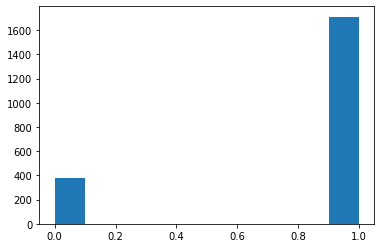

In [20]:
plt.hist(trapi_results_with_figures_df["p_value"])

## View TRAPI Results by PFOCR Figure

In [21]:
# This isn't really a significance threshold. It's more just intended to
# exclude results where the p-value is 1 or very close to it.
threshold = 0.9
significant_trapi_results_with_figures_df = trapi_results_with_figures_df[
    trapi_results_with_figures_df["p_value"] < 0.9
]

# all
cooccurrence_df = significant_trapi_results_with_figures_df.sort_values(
    "p_value"
)

### first and any other query node
##q_node_id_combination = (q_node_ids[0],)

## first and second query nodes
##q_node_id_combination = (q_node_ids[0], q_node_ids[1])

### first and last query nodes
##q_node_id_combination = (q_node_ids[0], q_node_ids[-1])

### second and last query nodes
##q_node_id_combination = (q_node_ids[1], q_node_ids[-1])

### every query node with 'ids' specified
##q_node_id_combination = query_nodes_with_ids

#print(f'{" & ".join(q_node_id_combination)}')
#s = pd.Series(
#    [True] * len(significant_trapi_results_with_figures_df),
#    index=significant_trapi_results_with_figures_dfindex
#)
#for q_node_id in q_node_id_combination:
#    s = s & significant_trapi_results_with_figures_df.apply(
#        lambda r: r[f'{q_node_id}_unified_curie'] in r["common_curie_set"], axis=1
#    )
#cooccurrence_df = significant_trapi_results_with_figures_df[s == True].sort_values(
#    "p_value"
#)

cooccurrence_df

,n0,e0,n1,e1,n2,n0_original_curie,n0_unified_curie,n1_original_curie,n1_unified_curie,n2_original_curie,...,figure_url,figure_title,figure_curie_count,common_curie_set,yes_trapi_result_yes_figure,yes_trapi_result_no_figure,no_trapi_result_yes_figure,no_trapi_result_no_figure,p_value,trapi_result_curies_key
1330,Imatinib mesylate,increases_activity_of,CASP3,contributes_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:836,NCBIGene:836,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Inhibitory roles of MSC-derived exosomes in tu...,27,"{MESH:D007938, NCBIGene:836}",2,1,25,30135,0.000002,"(MESH:D000068877, MESH:D007938, NCBIGene:836)"
2089,Imatinib mesylate,increases_activity_of,CASP8,correlated_with,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:841,NCBIGene:841,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Inhibitory roles of MSC-derived exosomes in tu...,27,"{NCBIGene:841, MESH:D007938}",2,1,25,30135,0.000002,"(MESH:D000068877, MESH:D007938, NCBIGene:841)"
1307,Imatinib mesylate,increases_activity_of,CASP3,correlated_with,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:836,NCBIGene:836,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Inhibitory roles of MSC-derived exosomes in tu...,27,"{MESH:D007938, NCBIGene:836}",2,1,25,30135,0.000002,"(MESH:D000068877, MESH:D007938, NCBIGene:836)"
1353,Imatinib mesylate,increases_degradation_of,CASP3,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:836,NCBIGene:836,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Inhibitory roles of MSC-derived exosomes in tu...,27,"{MESH:D007938, NCBIGene:836}",2,1,25,30135,0.000002,"(MESH:D000068877, MESH:D007938, NCBIGene:836)"
1284,Imatinib mesylate,increases_activity_of,CASP3,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:836,NCBIGene:836,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Inhibitory roles of MSC-derived exosomes in tu...,27,"{MESH:D007938, NCBIGene:836}",2,1,25,30135,0.000002,"(MESH:D000068877, MESH:D007938, NCBIGene:836)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,Imatinib mesylate,response_decreased_by,CDK6,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:1021,NCBIGene:1021,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Cancer pathway targets affected by curcumin,172,{NCBIGene:1021},1,2,171,29989,0.017010,"(MESH:D000068877, MESH:D007938, NCBIGene:1021)"
1986,Imatinib mesylate,increases_activity_of,JUN,gene_associated_with_condition,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:3725,NCBIGene:3725,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Cancer pathway targets affected by curcumin,172,{NCBIGene:3725},1,2,171,29989,0.017010,"(MESH:D000068877, MESH:D007938, NCBIGene:3725)"
2009,Imatinib mesylate,increases_activity_of,JUN,contributes_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:3725,NCBIGene:3725,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Cancer pathway targets affected by curcumin,172,{NCBIGene:3725},1,2,171,29989,0.017010,"(MESH:D000068877, MESH:D007938, NCBIGene:3725)"
974,Imatinib mesylate,increases_secretion_of,VEGFA,contributes_to,leukemia,PUBCHEM.COMPOUND:123596,MESH:D000068877,NCBIGene:7422,NCBIGene:7422,MONDO:0005059,...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,Cancer pathway targets affected by curcumin,172,{NCBIGene:7422},1,2,171,29989,0.017010,"(MESH:D000068877, MESH:D007938, NCBIGene:7422)"


In [22]:
from IPython.display import Image
from IPython.core.display import HTML 


outer_limit = 10
inner_limit = 10

count = 0
for figure_id, one_figure_id_df in cooccurrence_df.groupby("figure_id", sort=False):
    [pmc,filename] = figure_id.split("__")
    paper_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/"
    figure_url = f"https://www.ncbi.nlm.nih.gov/pmc/articles/{pmc}/bin/{filename}"
    figure_title = list(set(one_figure_id_df["figure_title"]))[0]

    display(HTML(data=f'''
<div style="border: 1px solid slategray; padding: 6px;">
    <figure style="margin: 5px !important;">
        <a target="_blank" href="{paper_url}">
          <img src="{figure_url}" style="max-height: 500px; max-width: 100%;">
        </a>
        <br>
        <caption>
            {figure_title}
        </caption>
    </figure>
</div>
'''))

    trapi_results_row_sets = []
    
    for trapi_result_curie_combo, one_trapi_result_curie_combo_df in one_figure_id_df[(
        trapi_result_columns +
        unified_curie_columns +
        ["trapi_result_curies_key", "common_curie_set", "p_value"]
    )].groupby("trapi_result_curies_key", sort=False):
        overlap_names = []
        for curie in one_trapi_result_curie_combo_df["common_curie_set"].tolist()[0]:
            name = curie_to_name[curie]
            overlap_names.append(name)

        trapi_results_rows = []
        for i,row in one_trapi_result_curie_combo_df.iterrows():
            trapi_result_chunks = []
            for trapi_result_column in trapi_result_columns:
                row_value = row[trapi_result_column]
                if row_value in overlap_names:
                    trapi_result_chunk = f'''
<span style="border: 1px orange solid; padding: 1px; border-radius: 4px;">{row_value}</span>
'''
                else:
                    trapi_result_chunk = f'{row_value}'
                trapi_result_chunks.append(trapi_result_chunk)
                
            trapi_results_rows.append(
                f'{" - ".join(trapi_result_chunks)}</span>'
            )
        
        ordered_trapi_result_curie_combo = []
        for unified_curie_column in unified_curie_columns:
            ordered_trapi_result_curie_combo.append(list(set(
                one_trapi_result_curie_combo_df[unified_curie_column]
            ))[0])
        
        p_value = list(set(one_trapi_result_curie_combo_df["p_value"]))[0]
        trapi_results_row_sets.append(f'''
<div>
    <span style="font-weight: bold; font-size: small;">
        TRAPI result {", ".join(ordered_trapi_result_curie_combo)}
    </span> 
    (p-value: {p_value:.1e})
    <br>
    {"<br>".join(trapi_results_rows)}
</div>
''')

    trapi_results_row_set_count = len(trapi_results_row_sets)
    display(HTML(data="<br>".join(trapi_results_row_sets[:inner_limit])))
    if trapi_results_row_set_count > inner_limit:
        print(f"...")
        print("")
        print(f"plus {trapi_results_row_set_count - inner_limit} more TRAPI results")
    print("")

    count += 1
    if count >= outer_limit:
        print("...")
        print("")
        print(f'''
plus {len(set(cooccurrence_df["figure_id"])) - outer_limit} more figures, each with TRAPI results
''')
        print("")
        break

...

plus 11 more TRAPI results




...


plus 13 more figures, each with TRAPI results


